In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from IPython import display
import time as t
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import random

env = gym.make('LunarLander-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/Users/adithyashanker/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [ ]:
episodes = 100
observations = []
rewards = []


for episode in range(episodes) :
    initial_state = env.reset()
    ended = False
    rewardsum = 0
    while not ended :
        env.render()
        action = env.action_space.sample()
        obs, reward, ended, info = env.step(action)
        #print(env.observation_space)
        observations.append(obs)
        rewardsum += reward
        #print(rewardsum)
    #t.sleep(5)

velocities = []
ang_velocities = []
for observation in observations :
    velocities.append(observation[1])
    ang_velocities.append(observation[3])

print (f'min velocity : {np.min(velocities)}, max velocity : {np.max(velocities)}\n')
print (f'min ang_velocity : {np.min(ang_velocities)}, max ang_velocity : {np.max(ang_velocities)}')
      
    



In [ ]:
print(observations[1])

In [ ]:
rewards = []


for episode in range(episodes) :
    initial_state = env.reset()
    ended = False
    rewardsum = 0
    while not ended :
        env.render()
        action = env.action_space.sample()
        obs, reward, ended, info = env.step(action)
        #print(env.observation_space)
        observations.append(obs)
        rewardsum += reward
        #print(rewardsum)
    t.sleep(5)

velocities = []
ang_velocities = []
for observation in observations :
    velocities.append(observation[1])
    ang_velocities.append(observation[3])

print (f'min velocity : {np.min(velocities)}, max velocity : {np.max(velocities)}\n')
print (f'min ang_velocity : {np.min(ang_velocities)}, max ang_velocity : {np.max(ang_velocities)}')
      
    



In [ ]:
def mapStateSpace(obs):

    max_position = 2.4 
    max_velocity = 5   
    max_angle = np.pi   
    max_angular_velocity = 4  

    # Normalize and discretize 
    a = np.round((obs[0] / max_position) * 10)  # Discretize position into 10 bins
    b = np.round((obs[1] / max_velocity) * 15)  # Discretize velocity into 10 bins
    c = np.round((obs[2] / max_angle) * 36)     # Discretize angle into 18 bins (~20 degrees each)
    d = np.round((obs[3] / max_angular_velocity) * 15)  # Discretize angular velocity into 10 bins

    return int(10*a + 10*b + 30*c + 10*d)
   
    

In [ ]:

n_states = 4000  
n_actions = 2

Q_table = np.zeros((n_states, n_actions))

learning_rate = 0.1
discount_factor = 1
exploration_prob = 0.2
epochs = 1000

for epoch in range(epochs):

    current_state = env.reset()
    #env.render()
    ended = False
    rewardsum = 0


    while not ended :

        if np.random.rand() < exploration_prob:
            action = env.action_space.sample()  
        else:
            action = np.argmax(Q_table[mapStateSpace(current_state)])  
        
        next_state, reward, ended, info = env.step(action)

        next_max = np.max(Q_table[mapStateSpace(next_state)])
        td_target = reward + discount_factor * next_max
        td_error = td_target - Q_table[mapStateSpace(current_state), action]
        Q_table[mapStateSpace(current_state), action] += learning_rate * td_error
        rewardsum += reward

        current_state = next_state 
    #print(rewardsum)
    

print("Learned Q-table:")

    







In [ ]:
episodes = 2000
rewards = []


for episode in range(episodes) :
    state = env.reset()
    ended = False
    rewardsum = 0
    while not ended :
        env.render()
        action = np.argmax(Q_table[mapStateSpace(state)])
        state, reward, ended, info = env.step(action)
        rewardsum += reward
    #print(rewardsum)
    #t.sleep(1)
    rewards.append(rewardsum)

print(np.max(rewards))

In [ ]:
plt.plot(range(len(rewards)), rewards)

In [3]:
class Model(nn.Module):

    def __init__(self, in_features=8, h1=64, h2=64, h3=64, out_features=4) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.2)
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

policy_network = Model()

In [4]:
import math


def epsilon_decay(epsilon_start, epsilon_final, steps, epsilon_decay):
    epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps / epsilon_decay)
    return epsilon

In [6]:
from collections import deque

learning_rate = 0.001
discount_factor = 0.99
initial_epsilon = 0.99
min_exploration_prob = 0.01
decay = 25

epochs = 5000

replay_buffer_batch_size = 64
min_replay_buffer_size = 100000
replay_buffer = deque(maxlen=min_replay_buffer_size)

target_network = Model()
target_network.load_state_dict(policy_network.state_dict())


optimizer = torch.optim.Adam(policy_network.parameters(), learning_rate)

loss_function = nn.MSELoss()

rewards = []

losses = []

total_steps = 0

loss = -100

for i in range(epochs) :


    terminal = False

    if i % 10 == 0 :
        target_network.load_state_dict(policy_network.state_dict())

    current_state = env.reset()

    rewardsum = 0

    p = False

    while not terminal :

        #env.render()

        exploration_prob = epsilon_decay(initial_epsilon, min_exploration_prob, total_steps, decay)


        if np.random.rand() < exploration_prob:
            action = env.action_space.sample()  
        else:
            state_tensor = torch.tensor(np.array([current_state]), dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_network(state_tensor)
            action = torch.argmax(q_values).item()
        
        total_steps+=1
        next_state, reward, terminal, info = env.step(action)

        

        rewardsum+=reward

        replay_buffer.append((current_state, action, terminal, reward, next_state))

        if(len(replay_buffer) >= min_replay_buffer_size) :

            minibatch = random.sample(replay_buffer, replay_buffer_batch_size)

            batch_states = torch.tensor([transition[0] for transition in minibatch], dtype=torch.float32)
            batch_actions = torch.tensor([transition[1] for transition in minibatch], dtype=torch.int64)
            batch_terminal = torch.tensor([transition[2] for transition in minibatch], dtype=torch.bool)
            batch_rewards = torch.tensor([transition[3] for transition in minibatch], dtype=torch.float32)
            batch_next_states = torch.tensor([transition[4] for transition in minibatch], dtype=torch.float32)

            with torch.no_grad():
                q_values_next = target_network(batch_next_states).detach()
                max_q_values_next = q_values_next.max(1)[0] 

            y = batch_rewards + (discount_factor * max_q_values_next * (~batch_terminal))

            q_values = policy_network(batch_states).gather(1, batch_actions.unsqueeze(-1)).squeeze(-1)

            loss = loss_function(y,q_values)

            losses.append(loss)

            optimizer.zero_grad()
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), 10)

            optimizer.step()

        if i%100 == 0 and not p:
            print(loss)
            p = True

        current_state = next_state
        
        

    rewards.append(rewardsum)

torch.save(policy_network, 'lunar_game.pth')


-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100


/var/folders/sy/2jzm18gs78s48trcqgthb1xh0000gn/T/ipykernel_62032/107616033.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch_states = torch.tensor([transition[0] for transition in minibatch], dtype=torch.float32)


tensor(79.3885, grad_fn=<MseLossBackward0>)
tensor(2.9302, grad_fn=<MseLossBackward0>)
tensor(0.5425, grad_fn=<MseLossBackward0>)
tensor(4.6607, grad_fn=<MseLossBackward0>)
tensor(1.0427, grad_fn=<MseLossBackward0>)
tensor(1.7811, grad_fn=<MseLossBackward0>)
tensor(12.0813, grad_fn=<MseLossBackward0>)
tensor(3.7673, grad_fn=<MseLossBackward0>)
tensor(286.3869, grad_fn=<MseLossBackward0>)
tensor(0.7295, grad_fn=<MseLossBackward0>)
tensor(11.7655, grad_fn=<MseLossBackward0>)
tensor(27.8934, grad_fn=<MseLossBackward0>)
tensor(2.4923, grad_fn=<MseLossBackward0>)
tensor(4.6464, grad_fn=<MseLossBackward0>)
tensor(0.8472, grad_fn=<MseLossBackward0>)
tensor(47.9638, grad_fn=<MseLossBackward0>)
tensor(163.0980, grad_fn=<MseLossBackward0>)
tensor(2.6291, grad_fn=<MseLossBackward0>)
tensor(441.7270, grad_fn=<MseLossBackward0>)
tensor(1.4858, grad_fn=<MseLossBackward0>)
tensor(5.5385, grad_fn=<MseLossBackward0>)
tensor(476.8307, grad_fn=<MseLossBackward0>)
tensor(1.2724, grad_fn=<MseLossBackward0>

tensor(1.5648, grad_fn=<MseLossBackward0>)


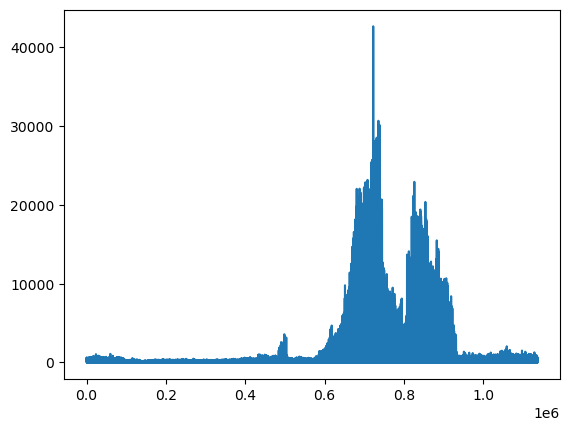

In [8]:


plt.plot(range(len(losses)), [l.detach().numpy() for l in losses])

#print(np.min(losses), axis = 1)

print(losses[len(losses)-1])

#torch.save(policy_network, 'stick_game.pth')



In [11]:
with torch.no_grad():
    episodes = 2000
    rewards = []


    for episode in range(episodes) :
        state = env.reset()
        ended = False
        rewardsum = 0
        #state, reward, ended, info = env.step(env.action_space.sample())
        state, reward, ended, info = env.step(env.action_space.sample())
        while not ended :
            env.render()
            #state, reward, ended, info = env.step(env.action_space.sample())
            state_tensor = torch.tensor([state], dtype=torch.float32)
            q_values = policy_network(state_tensor)
            action = torch.argmax(q_values).item()

            state, reward, ended, info = env.step(action)
            rewardsum += reward
        print(rewardsum)
        t.sleep(1)
        rewards.append(rewardsum)

print(np.max(rewards))
        

283.92980706099115
290.73968600879505
261.0219016345902


KeyboardInterrupt: 